# A6
## Part1 - Estimate fundamental frequency in polyphonic audio signal

In [1]:
import os
import sys
import numpy as np
import math
from scipy.signal import get_window
import matplotlib.pyplot as plt

sys.path.append('../../software/models/')
import utilFunctions as UF
import harmonicModel as HM
import sineModel as SM
import stft

import loadTestCases

eps = np.finfo(float).eps

Set the analysis parameters used within the function estimateF0() to obtain a good estimate of the 
fundamental frequency (`f0`) corresponding to one melody within a complex audio signal. The signal 
is a cello recording `cello-double-2.wav`, in which two strings are played simultaneously. One string 
plays a constant drone while the other string plays a simple melody. You have to choose the analysis 
parameter values such that only the `f0` frequency of the simple melody is tracked.

The input argument to the function is the wav file name including the path (`inputFile`). The function 
returns a numpy array of the `f0` frequency values for each audio frame. For this question we take 
hopSize (`H`) = 256 samples. 

`estimateF0()` calls `f0Detection()` function of the `harmonicModel.py`, which uses the two way mismatch 
algorithm for `f0` estimation. 

`estimateF0()` also plots the `f0` contour on top of the spectrogram of the audio signal for you to 
visually analyse the performance of your chosen values for the analysis parameters. In this question 
we will only focus on the time segment between 0.5 and 4 seconds. So, your analysis parameter values 
should produce a good `f0` contour in this time region.

In addition to plotting the `f0` contour on the spectrogram, this function also synthesizes the `f0` 
contour. You can also evaluate the performance of your chosen analysis parameter values by listening 
to this synthesized wav file named `'synthF0Contour.wav'`

Since there can be numerous combinations of the optimal analysis parameter values, the evaluation is 
done solely on the basis of the output `f0` sequence. Note that only the segment of the `f0` contour 
between time 0.5 to 4 seconds is used to evaluate the performance of `f0` estimation.

Your assignment will be tested only on inputFile = `'../../sounds/cello-double-2.wav'`. So choose the 
analysis parameters using which the function estimates the `f0` frequency contour corresponding to the 
string playing simple melody and not the drone. There is no separate test case for this question. 
You can keep working with the wav file mentioned above and when you think the performance is 
satisfactory you can submit the assignment. The plots can help you achieve a good performance. 

Be cautious while choosing the window size. Window size should be large enough to resolve the spectral 
peaks and small enough to preserve the note transitions. Very large window sizes may smear the `f0` 
contour at note transitions.

Depending on the parameters you choose and the capabilities of the hardware you use, the function 
might take a while to run (even half a minute in some cases). For this part of the assignment please 
refrain from posting your analysis parameters on the discussion forum. 

In [2]:
!play ../../sounds/cello-double-2.wav


../../sounds/cello-double-2.wav:

 File Size: 604k      Bit Rate: 706k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 44100Hz      
Replaygain: off         
  Duration: 00:00:06.85  

In:100%  00:00:06.85 [00:00:00.00] Out:302k  [      |      ]        Clip:0    
Done.


In [3]:
def estimateF0(inputFile = '../../sounds/cello-double-2.wav'):
    """
    Function to estimate fundamental frequency (f0) in an audio signal. This function also plots the 
    f0 contour on the spectrogram and synthesize the f0 contour.
    Input:
        inputFile (string): wav file including the path
    Output:
        f0 (numpy array): array of the estimated fundamental frequency (f0) values
    """

    ### Change these analysis parameter values marked as XX
    window = 'blackmanharris'
    M = 7001
    N = 4096*2
    f0et = 2
    t = -90
    minf0 = 135
    maxf0 = 210

    ### Do not modify the code below 
    H = 256                                                     #fix hop size
      
    fs, x = UF.wavread(inputFile)                               #reading inputFile
    w  = get_window(window, M)                                  #obtaining analysis window    
    
    ### Method 1
    f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)  #estimating F0
    startFrame = int(np.floor(0.5*fs/H))    
    endFrame = int(np.ceil(4.0*fs/H))
    f0[:startFrame] = 0
    f0[endFrame:] = 0
    y = UF.sinewaveSynth(f0, 0.8, H, fs)
    UF.wavwrite(y, fs, 'synthF0Contour.wav')

    ## Code for plotting the f0 contour on top of the spectrogram
    # frequency range to plot
    maxplotfreq = 500.0    
    fontSize = 16
    plot = 1

    fig = plt.figure()
    ax = fig.add_subplot(111)

    mX, pX = stft.stftAnal(x, w, N, H)                      #using same params as used for analysis
    mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])
    
    timeStamps = np.arange(mX.shape[1])*H/float(fs)                             
    binFreqs = np.arange(mX.shape[0])*fs/float(N)
    
    plt.pcolormesh(timeStamps, binFreqs, mX)
    plt.plot(timeStamps, f0, color = 'k', linewidth=1.5)
    plt.plot([0.5, 0.5], [0, maxplotfreq], color = 'b', linewidth=1.5)
    plt.plot([4.0, 4.0], [0, maxplotfreq], color = 'b', linewidth=1.5)
    
    
    plt.autoscale(tight=True)
    plt.ylabel('Frequency (Hz)', fontsize = fontSize)
    plt.xlabel('Time (s)', fontsize = fontSize)
    plt.legend(('f0',))
    
    xLim = ax.get_xlim()
    yLim = ax.get_ylim()
    ax.set_aspect((xLim[1]-xLim[0])/(2.0*(yLim[1]-yLim[0])))    

    if plot == 1: #save the plot too!
        plt.autoscale(tight=True) 
        plt.show()
    else:
        fig.tight_layout()
        fig.savefig('f0_over_Spectrogram.png', dpi=150, bbox_inches='tight')

    return f0


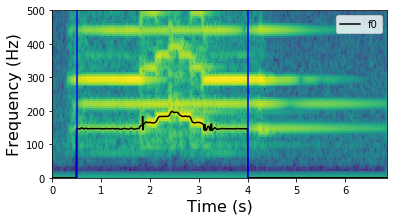

In [4]:
# test
f0 = estimateF0()

In [5]:
!play synthF0Contour.wav


synthF0Contour.wav:

 File Size: 605k      Bit Rate: 706k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 44100Hz      
Replaygain: off         
  Duration: 00:00:06.86  

In:100%  00:00:06.86 [00:00:00.00] Out:302k  [      |      ] Hd:1.9 Clip:0    
Done.


## Part 2 - Segmentation of stable note regions in an audio signal

Complete the function `segmentStableNotesRegions()` to identify the stable regions of notes in a specific 
monophonic audio signal. The function returns an array of segments where each segment contains the 
starting and the ending frame index of a stable note.

The input argument to the function are the wav file name including the path (`inputFile`), threshold to 
be used for deciding stable notes (`stdThsld`) in cents, minimum allowed duration of a stable note (`minNoteDur`), 
number of samples to be considered for computing standard deviation (`winStable`), analysis window (`window`), 
window size (`M`), FFT size (`N`), hop size (`H`), error threshold used in the f0 detection (`f0et`), magnitude 
threshold for spectral peak picking (`t`), minimum allowed f0 (`minf0`) and maximum allowed f0 (`maxf0`). 
The function returns a numpy array of `shape (k,2)`, where `k` is the total number of detected segments. 
The two columns in each row contains the starting and the ending frame indexes of a stable note segment. 
The segments must be returned in the increasing order of their start times. 

In order to facilitate the assignment we have configured the input parameters to work with a particular 
sound, `'../../sounds/sax-phrase-short.wav'`. The code and parameters to estimate the fundamental frequency 
is completed. Thus you start from an `f0` curve obtained using the `f0Detection()` function and you will use 
that to obtain the note segments. 

All the steps to be implemented in order to solve this question are indicated in `segmentStableNotesRegions()` 
as comments. These are the steps:

1. In order to make the processing musically relevant, the `f0` values should be converted first from Hertz to Cents, which is a logarithmic scale. 

2. At each time frame (for each `f0` value) you should compute the standard deviation of the past `winStable` number of `f0` samples (including the `f0` sample at the current audio frame). 

3. You should then apply a deviation threshold, `stdThsld`, to determine if the current frame belongs to a stable note region or not. Since we are interested in the stable note regions, the standard deviation of the previous `winStable` number of `f0` samples (including the current sample) should be less than `stdThsld` i.e. use the current sample and `winStable-1` previous samples. Ignore the first `winStable-1` samples in this computation.

4. All the consecutive frames belonging to the stable note regions should be grouped together into segments. For example, if the indexes of the frames corresponding to the stable note regions are 3,4,5,6,12,13,14, we get two segments, first 3-6 and second 12-14. 

5. After grouping frame indexes into segments filter/remove the segments which are smaller in duration than `minNoteDur`. Return the segment indexes in the increasing order of their start frame index.

In [6]:
def segmentStableNotesRegions(inputFile = '../../sounds/sax-phrase-short.wav', stdThsld=10, minNoteDur=0.1, 
                              winStable = 3, window='hamming', M=1024, N=2048, H=256, f0et=5.0, t=-100, 
                              minf0=310, maxf0=650):
    """
    Function to segment the stable note regions in an audio signal
    Input:
        inputFile (string): wav file including the path
        stdThsld (float): threshold for detecting stable regions in the f0 contour (in cents)
        minNoteDur (float): minimum allowed segment length (note duration)  
        winStable (integer): number of samples used for computing standard deviation
        window (string): analysis window
        M (integer): window size used for computing f0 contour
        N (integer): FFT size used for computing f0 contour
        H (integer): Hop size used for computing f0 contour
        f0et (float): error threshold used for the f0 computation
        t (float): magnitude threshold in dB used in spectral peak picking
        minf0 (float): minimum fundamental frequency in Hz
        maxf0 (float): maximum fundamental frequency in Hz
    Output:
        segments (np.ndarray): Numpy array containing starting and ending frame indexes of every segment.
    """
    fs, x = UF.wavread(inputFile)                               #reading inputFile
    w  = get_window(window, M)                                  #obtaining analysis window    
    f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)  #estimating F0

    ### your code here
    # 1. convert f0 values from Hz to Cents (as described in pdf document)
    f0[ f0 < eps ] = eps
    f0_cent = Hz2Cent(f0)
    
    #2. create an array containing standard deviation of last winStable samples
    std_val_array = compute_std(f0_cent, winStable)

    #3. apply threshold on standard deviation values to find indexes of the stable points in melody
    stable_frame_index = find_stable_index(std_val_array, stdThsld, winStable)
    
    #4. create segments of continuous stable points such that consecutive stable points belong to same segment
    segments = group_stable_frame_index(stable_frame_index)
    
    #5. apply segment filtering, i.e. remove segments with are < minNoteDur in length
    num_frame = f0.size
    each_frame_duration = x.size / (fs*num_frame)
    
    filtered_segments = filter_segments_by_min_duration(segments, minNoteDur, each_frame_duration)
    
    plotSpectogramF0Segments(x, fs, w, N, H, f0, segments)  # Plot spectrogram and F0 if needed

    # return segments
    return filtered_segments
    
def Hz2Cent(hz):
    
    A1 = 55.0
    return 1200.0 * np.log2(hz/A1)

def compute_std(f0_cent, winStable):
    '''
    compute the standard deviation of the
    past winStable number of f 0 samples (including the f 0 sample at the current audio frame).
    
    f0_cent(numpy array) : cent array of f0
    winStable : compute the std of the past winStable number of f0_cent
    
    returns
    std_val_array(numpy array): std array of f0 (ignore the first winStable -1 points)
    '''
    
    std_val_array = np.array([ np.std(f0_cent[i-winStable:i]) for i in range(winStable, f0_cent.size + 1) ])
    
    return std_val_array

def find_stable_index(std_val_array, t, winStable):
    '''
    You should then apply a deviation threshold, stdThsld, to determine if the current frame
    belongs to a stable note region or not
    
    std_val_array(numpy array): std array of f0 (ignore the first winStable -1 points)
    t : threshold 
    winStable: we add winStable to compensate index
    
    returns
    stable_frame_index: a number set which contains the consectutive frame index
    '''
    
    stable_frame_index = np.where( std_val_array < t )[0] + winStable - 1
    
    
    return stable_frame_index

def group_stable_frame_index(stable_frame_index):
    '''
    All the consecutive frames belonging to the stable note regions should be grouped together
    into segments. For example, if the indexes of the frames corresponding to the stable note
    regions are 3,4,5,6,12,13,14, we get two segments, first 3-6 and second 12-14.
    
    stable_frame_index(numpy array) : a number set which contains the consectutive frame index
    
    returns
    segments(numpy array): shape is (k, 2), k is the number of segment,
                           2 columns in each row contains the starting and the ending frame indexs
    '''
    
    starting = -1
    ending = -1
    pre_index = -1
    segments = list()
    
    for index in stable_frame_index:
        
        if starting == -1:                       # initial state
            starting = index
            pre_index = index
            continue
        elif index - pre_index != 1:             # do a segment
            ending =  pre_index
            segments.append([starting, ending])
            
            # reset the state
            starting = index
        
        pre_index = index
        
    # insert the last starging adn ending index to segments array    
    segments.append([starting, pre_index])
            
    return np.asarray(segments)

def filter_segments_by_min_duration(segments, minNoteDur, each_frame_duration):
    '''
    After grouping frame indexes into segments filter/remove the segments which are smaller in
    duration than minNoteDur. Return the segments in the increasing order of their start frame
    index.
    
    segments(numpy array): shape is (k, 2), k is the number of segment,
                           2 columns in each row contains the starting and the ending frame indexs
    minNoteDur(float) : minimun second of duration
    each_frame_duration(float) : duration of each frame
    
    returns
    filterd_segments : segments which are larger than the minimun duration
    '''
    
    duration_time = (segments[:, 1] - segments[:, 0])*each_frame_duration
    
    x = np.where( duration_time >= minNoteDur )
    filtered_segments = segments[x]
    
    return filtered_segments

In [7]:
# test functions

def EQ_double(x, y):
    return np.all(abs(x-y) < 1e-7)

def EQ(x, y):
    return np.all(x == y)

# test Hz2Cent
assert( EQ_double(Hz2Cent(55), 0.0))
assert( EQ_double(Hz2Cent(np.array([55,55])), np.array([0,0])) )

# test standard deviation computation
f0_cent = np.asarray([1,2,3,4,5,6,7,8,9,10])
winStable = 5
std_val_array = compute_std(f0_cent, winStable)
assert( std_val_array.size ==  f0_cent.size - winStable + 1)
assert( EQ_double(std_val_array, np.array([1.41421356, 1.41421356, 1.41421356, 
                                           1.41421356, 1.41421356, 1.41421356]) ) )

# test applying a threshold to std_val_array
std_val_array = np.array([10])
winStable = 5
t = 1.2
stable_frame_index = find_stable_index(std_val_array, t, winStable)
assert( stable_frame_index.size == 0)

std_val_array = np.array([1,2,2,1])
winStable = 5
t = 1.2
stable_frame_index = find_stable_index(std_val_array, t, winStable)
assert( EQ(stable_frame_index, np.array([4,7])) )


# test segments
stable_frame_index = np.array([3])
segments = group_stable_frame_index(stable_frame_index)
assert( segments.shape[1] == 2 )
assert( EQ( segments, np.array([[3,3]]) ) )

stable_frame_index = np.array([3,4,5,6,12,13,14])
segments = group_stable_frame_index(stable_frame_index)
assert( EQ( segments, np.array([[3,6], [12,14]]) ) )

# test the segments filter
gourped_frame_index = np.array([[3,3]], dtype='int')
num_frame = 10
fs = 44100
length_x = 441000
minNoteDur = 5

each_frame_duration = length_x/(fs*num_frame)

filtered_segments = filter_segments_by_min_duration(gourped_frame_index, minNoteDur, each_frame_duration)
assert( filtered_segments.size == 0 )

gourped_frame_index = np.array([[3,4]], dtype='int')
minNoteDur = 0
filtered_segments = filter_segments_by_min_duration(gourped_frame_index, minNoteDur, each_frame_duration)
assert( EQ( filtered_segments, np.array([[3,4]]) ) )

In [8]:
def plotSpectogramF0Segments(x, fs, w, N, H, f0, segments):
    """
    Code for plotting the f0 contour on top of the spectrogram
    """
    # frequency range to plot
    maxplotfreq = 1000.0    
    fontSize = 16

    fig = plt.figure()
    ax = fig.add_subplot(111)

    mX, pX = stft.stftAnal(x, w, N, H)                      #using same params as used for analysis
    mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])
    
    timeStamps = np.arange(mX.shape[1])*H/float(fs)                             
    binFreqs = np.arange(mX.shape[0])*fs/float(N)
    
    plt.pcolormesh(timeStamps, binFreqs, mX)
    plt.plot(timeStamps, f0, color = 'k', linewidth=5)

    for ii in range(segments.shape[0]):
        plt.plot(timeStamps[segments[ii,0]:segments[ii,1]], f0[segments[ii,0]:segments[ii,1]], color = '#A9E2F3', linewidth=1.5)        
    
    plt.autoscale(tight=True)
    plt.ylabel('Frequency (Hz)', fontsize = fontSize)
    plt.xlabel('Time (s)', fontsize = fontSize)
    plt.legend(('f0','segments'))
    
    xLim = ax.get_xlim()
    yLim = ax.get_ylim()
    ax.set_aspect((xLim[1]-xLim[0])/(2.0*(yLim[1]-yLim[0])))    
    plt.autoscale(tight=True) 
    plt.show()

Test case 1: Using `inputFile='../../sounds/cello-phrase.wav', stdThsld=10, minNoteDur=0.1, 
winStable = 3, window='hamming', M=1025, N=2048, H=256, f0et=5.0, t=-100, minf0=310, maxf0=650`, 
the function `segmentStableNotesRegions()` should return 9 segments. 

Please use `loadTestcases.load()` 
to check the expected segment indexes in the output.

Test case 2: Using `inputFile='../../sounds/cello-phrase.wav', stdThsld=20, minNoteDur=0.5, 
winStable = 3, window='hamming', M=1025, N=2048, H=256, f0et=5.0, t=-100, minf0=310, maxf0=650`, 
the function `segmentStableNotesRegions()` should return 6 segments. Please use loadTestcases.load() 
to check the expected segment indexes in the output.

Test case 3: Using `inputFile='../../sounds/sax-phrase-short.wav', stdThsld=5, minNoteDur=0.6, 
winStable = 3, window='hamming', M=1025, N=2048, H=256, f0et=5.0, t=-100, minf0=310, maxf0=650`, 
the function `segmentStableNotesRegions()` should return just one segment. Please use `loadTestcases.load()` 
to check the expected segment indexes in the output. 

We also provide the function `plotSpectogramF0Segments()` to plot the `f0` contour and the detected 
segments on the top of the spectrogram of the audio signal in order to visually analyse the outcome 
of your function. Depending on the analysis parameters and the capabilities of the hardware you 
use, the function might take a while to run (even half a minute in some cases). 

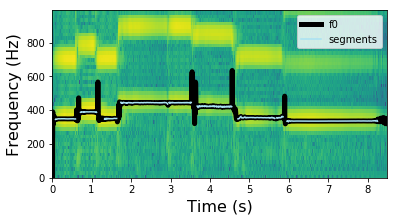

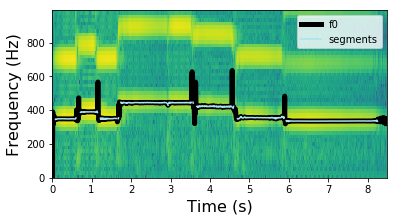

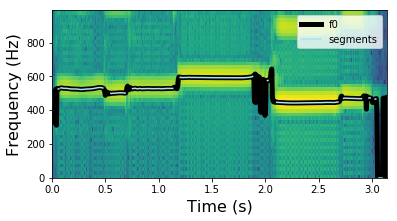

In [9]:
## Your plots here
# test

for i in range(1,4):
    data = loadTestCases.load(2,i)
    input_data = data['input']
    output_data = data['output']
    
    
    segments = segmentStableNotesRegions(input_data['inputFile'], input_data['stdThsld'],
                                        input_data['minNoteDur'], input_data['winStable'],
                                        input_data['window'], input_data['M'], input_data['N'],
                                        input_data['H'], input_data['f0et'],input_data['t'],
                                        input_data['minf0'],input_data['maxf0'])
    
    assert( EQ( output_data, segments ) )

## Part 3 - Compute amount of inharmonicity present in a sound

Write a function that measures the amount of inharmonicity present in a pitched/harmonic sound. The 
function should measure the mean inharmonicity in the sound over the time interval `t1` to `t2`.

The input argument to the function are the wav file name including the path (`inputFile`), start (`t1`) 
and end time (`t2`) of the audio segment to compute inharmonicity, analysis window (`window`), window 
size (`M`), FFT size (`N`), hop size (`H`), error threshold used in the `f0` detection (`f0et`), magnitude 
threshold for spectral peak picking (`t`), minimum allowed f0 (`minf0`), maximum allowed f0 (`maxf0`) and 
number of harmonics to be considered in the computation of inharmonicity (`nH`). The function returns 
a single numpy float, which is the mean inharmonicity over time `t1` to `t2`. 

A brief description of the method to compute inharmonicity is provided in the Relevant Concepts 
section of the assignment pdf. The steps to be done are:

1. Use `harmonicModelAnal` function in harmonicModel module for computing the harmonic frequencies and their magnitudes at each audio frame. The first harmonic is the fundamental frequency. For `harmonicModelAnal` use `harmDevSlope=0.01`, `minSineDur=0.0`. Use `harmonicModelAnal` to estimate harmonic frequencies and magnitudes for the entire audio signal.

2. For the computation of the inharmonicity choose the frames that are between the time interval `t1` and `t2`. Do not slice the audio signal between the time interval `t1` and `t2` before estimating harmonic frequencies. 

3. Use the formula given in the Relevant Concepts section to compute the inharmonicity measure for the given interval. Note that for some frames some of the harmonics might not be detected due to their low energy. For handling such cases use only the detected harmonics (and set the value of `R` in the equation to the number of detected hamonics) to compute the inharmonicity measure. All the detected harmonics have a non-zero frequency.

In this question we will work with a piano sound (`'../../sounds/piano.wav'`), a typical example of an 
instrument that exhibits inharmonicity 
(http://en.wikipedia.org/wiki/Piano_acoustics#Inharmonicity_and_piano_size). 


In [54]:
def estimateInharmonicity(inputFile = '../../sounds/piano.wav', t1=0.1, t2=0.5, window='hamming', 
                            M=2048, N=2048, H=128, f0et=5.0, t=-90, minf0=130, maxf0=180, nH = 10):
    """
    Function to estimate the extent of inharmonicity present in a sound
    Input:
        inputFile (string): wav file including the path
        t1 (float): start time of the segment considered for computing inharmonicity
        t2 (float): end time of the segment considered for computing inharmonicity
        window (string): analysis window
        M (integer): window size used for computing f0 contour
        N (integer): FFT size used for computing f0 contour
        H (integer): Hop size used for computing f0 contour
        f0et (float): error threshold used for the f0 computation
        t (float): magnitude threshold in dB used in spectral peak picking
        minf0 (float): minimum fundamental frequency in Hz
        maxf0 (float): maximum fundamental frequency in Hz
        nH (integer): number of integers considered for computing inharmonicity
    Output:
        meanInharm (float or np.float): mean inharmonicity over all the frames between the time interval 
                                        t1 and t2. 
    """
    # 0. Read the audio file and obtain an analysis window
    fs, x = UF.wavread(inputFile)                               #reading inputFile
    w  = get_window(window, M)                                  #obtaining analysis window
    f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)  #estimating F0

    
    # 1. Use harmonic model to compute the harmonic frequencies and magnitudes
    xhreq, xhmag, xhphase = HM.harmonicModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et)
        
    # 2. Extract the time segment in which you need to compute the inharmonicity.
    starting = int( np.ceil(fs*t1/H) )
    ending = int( np.floor(fs*t2/H) )
    
    # 3. Compute the mean inharmonicity of the segment
    mean_inharmonicity = compute_inharmonicity(xhreq, starting, ending, nH)
    
    return mean_inharmonicity

def compute_inharmonicity(xhreq, starting, ending, nH):
    
    inharmonicity_array = np.array([])
    
    xseg_hreq = xhreq[starting:ending]

    I = np.zeros(xseg_hreq.shape[0])
    for l in range(0, xseg_hreq.shape[0]):
        nonZeroFreqs = np.where(xseg_hreq[l] > 0.0)[0]
        nonZeroFreqs = np.delete(nonZeroFreqs, 0)
        for r in nonZeroFreqs:
            I[l] += ( np.abs(xseg_hreq[l, r] - (r+1)*xseg_hreq[l, 0]) )/float(r+1)
        I[l] = 1.0 / nH * I[l]

    mean_inharmonicity = 1.0/(ending - starting) * np.sum(I)    
    return mean_inharmonicity

In [56]:
## Your plots here
# test

for i in range(1,4):
    data = loadTestCases.load(3,i)
    input_data = data['input']
    output_data = data['output']
    
    mean_inharmonicity = estimateInharmonicity(input_data['inputFile'], input_data['t1'],
                          input_data['t2'], input_data['window'], 
                          input_data['M'], input_data['N'],input_data['H'],
                          input_data['f0et'],input_data['t'],input_data['minf0'],
                          input_data['maxf0'],input_data['nH'] )
    print(output_data)
    assert( np.abs(mean_inharmonicity - output_data) < 1e-2 )

1.4543199875221113
1.4874113486199498
0.17476486475550676


Test case 1: If you run your code with `inputFile = '../../sounds/piano.wav', t1=0.2, t2=0.4, window='hamming', M=2047, N=2048, H=128, f0et=5.0, t=-90, minf0=130, maxf0=180, nH = 25`, the returned output should be `1.4543`. 

Test case 2: If you run your code with `inputFile = '../../sounds/piano.wav', t1=2.3, t2=2.55, window='hamming', M=2047, N=2048, H=128, f0et=5.0, t=-90, minf0=230, maxf0=290, nH = 15`, the returned output should be `1.4874`. 

Test case 3: If you run your code with `inputFile = '../../sounds/piano.wav', t1=2.55, t2=2.8, window='hamming', M=2047, N=2048, H=128, f0et=5.0, t=-90, minf0=230, maxf0=290, nH = 5`, the returned output should be `0.1748`. 

Optional/Additional tasks
An interesting task would be to compare the inharmonicities present in the sounds of different instruments. 

## Part 4 - Improving the implementation of the two way mismatch f0 estimation algorithm

Improve the performance of the current implementation of the two way mismatch algorithm in sms-tools 
used for fundamental frequency estimation. This is an optional open question and will not contribute 
towards the final grade. There is no definite answer for this question. Its main purpose is to 
understand the limitations of the current implementations of the TWM algorithm and to come up with 
some community driven solutions based on collective thinking. 

In this question you will directly modify the core functions that implement the TWM algorithm in 
sms-tools. To assist you with this task, we have copied all the needed functions into this python 
file. Hence, you just need to modify the functions in this file and not anywhere else.

Estimating fundamental frequency from an audio signal is still a challenging and unsolved problem 
to a large extent. By this time you might have also realized that many times the performance of the 
TWM `f0` estimation algorithm falls short of the expectations. There can be a systematic explanation 
for the scenarios where TWM fails for specific categories or characteristics of the sounds. Some of 
the known scenarios where the current implementation of the TWM algorithm fails to estimate a correct 
fundamental frequency are:

1) Missing fundamental frequency: For many sounds the fundamental frequency component is very low and therefore during the spectral peak picking step we do not obtain any peak corresponding to the `f0`. Since the TWM algorithm implemented in sms-tools considers only the detected spectral peaks as the `f0` candidates, we do not get any candidate corresponding to the `f0`. This causes `f0` estimation to fail. For example, such a scenario is encountered in low pitched vocal sounds.

2) Pseudo-harmonicity in the sound. Many instruments such as piano exhibit some deviation from perfect harmonicity wherein their harmonic partials are not perfectly located at integral multiples of the fundamental frequency. Since the TWM algorithm computes error function assuming that the harmonic locations are at integral multiples, its performance is poorer when such deviations exist.

In this question we propose to work on these two scenarios. Go to freesound and download sound examples 
of low pitched vocal sounds and of piano. Run current implementation of TMW to identify the limitations 
and propose improvements to the code in order to obtain better `f0` estimation for those two particular 
scenarios. 

The core TWM algorithm is implemented in the function `TWM_p()`, which takes in an array of `f0` candidates 
and detect the candidate that has the lowest error. `TWM_p()` is called by `f0Twm()`, which generates 
`f0` candidates `(f0c = np.argwhere((pfreq>minf0) & (pfreq<maxf0))[:,0])`. This function also implements 
a memory based prunning of the `f0` candidates. If the `f0` contour is found to be stable (no drastic 
transitions across frames) then only the `f0` candidates close to the stable `f0` value are retained. 
`f0Twm()` is called for every audio frame by `f0Detection()`.

You can use `computeAndPlotF0()`, which calls `f0Detection()` for estimating `f0` for every audio frame. 
In addition, it also plots the `f0` contour on the top of the spectrogram. If you set `plot=1`, it shows 
the plot, `plot=2` saves the plot as can be seen in the code. 

Once you implement your proposed enhancement, discuss and share your ideas on the discussion forum 
assigned for A6Part4 - https://class.coursera.org/audio-001/forum/list?forum_id=10026. Along with the 
text you should include 2 plots showing the `f0` contour before and after your changes. Use the same 
values of the analysis parameters while showing the improvement in the performance. in the discussion, 
also include a link to the sound in freesound. 

TIP: An identified limitation of the current implementation for the case of low vocal sounds is that 
it can only find `f0` if there is a peak present in the magnitude spectrum. A possible improvement is 
to generate additional `f0` candidates from the identified peaks. Another identified limitation for 
the case of piano sounds is the assumption of perfect harmonicity. For these sounds you can think 
of modifying the generation of the ideal harmonic series that is computed in the code, incorporating 
the typical deviation from harmonicity encountered in piano sounds.

NOTE: Before you start making changes in the TWM implementation make sure you have reached the best 
possible performance that can be achieved by tuning the analysis parameters. If the analysis parameters 
are inappropriately set, it is not completely meaningful to just improve the TWM implementation.

To maintain the integrity if the sms-tools package for future assignments, please make changes only 
to the functions in this file and not the other files in sms-tools.

In [ ]:
def computeAndPlotF0(inputFile = '../../sounds/piano.wav'):
    """
    Function to estimate fundamental frequency (f0) in an audio signal using TWM.
    Input:
        inputFile (string): wav file including the path    
    """
    window='hamming'
    M=2048
    N=2048
    H=256
    f0et=5.0
    t=-80
    minf0=100
    maxf0=300

    fs, x = UF.wavread(inputFile)                               #reading inputFile
    w  = get_window(window, M)                                  #obtaining analysis window    
    f0 = f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)  #estimating F0

    ## Code for plotting the f0 contour on top of the spectrogram
    # frequency range to plot
    maxplotfreq = 500.0    
    fontSize = 16
    plot = 1

    fig = plt.figure()
    ax = fig.add_subplot(111)

    mX, pX = stft.stftAnal(x, w, N, H)                      #using same params as used for analysis
    mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])
    
    timeStamps = np.arange(mX.shape[1])*H/float(fs)                             
    binFreqs = np.arange(mX.shape[0])*fs/float(N)
    
    plt.pcolormesh(timeStamps, binFreqs, mX)
    plt.plot(timeStamps, f0, color = 'k', linewidth=1.5)
    
    plt.autoscale(tight=True)
    plt.ylabel('Frequency (Hz)', fontsize = fontSize)
    plt.xlabel('Time (s)', fontsize = fontSize)
    plt.legend(('f0',))
    
    xLim = ax.get_xlim()
    yLim = ax.get_ylim()
    ax.set_aspect((xLim[1]-xLim[0])/(2.0*(yLim[1]-yLim[0])))    

    if plot == 1: 
        plt.autoscale(tight=True) 
        plt.show()
    elif plot == 2:                   #you can save the plot too!
        fig.tight_layout()
        fig.savefig('f0_over_Spectrogram.png', dpi=150, bbox_inches='tight')


In [ ]:
def f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et):
    """
    Fundamental frequency detection of a sound using twm algorithm
    x: input sound; fs: sampling rate; w: analysis window; 
    N: FFT size; t: threshold in negative dB, 
    minf0: minimum f0 frequency in Hz, maxf0: maximim f0 frequency in Hz, 
    f0et: error threshold in the f0 detection (ex: 5),
    returns f0: fundamental frequency
    """
    if (minf0 < 0):                                            # raise exception if minf0 is smaller than 0
        raise ValueError("Minumum fundamental frequency (minf0) smaller than 0")
    
    if (maxf0 >= 10000):                                       # raise exception if maxf0 is bigger than fs/2
        raise ValueError("Maximum fundamental frequency (maxf0) bigger than 10000Hz")
    
    if (H <= 0):                                               # raise error if hop size 0 or negative
        raise ValueError("Hop size (H) smaller or equal to 0")
        
    hN = N/2                                                   # size of positive spectrum
    hM1 = int(math.floor((w.size+1)/2))                        # half analysis window size by rounding
    hM2 = int(math.floor(w.size/2))                            # half analysis window size by floor
    x = np.append(np.zeros(hM2),x)                             # add zeros at beginning to center first window at sample 0
    x = np.append(x,np.zeros(hM1))                             # add zeros at the end to analyze last sample
    pin = hM1                                                  # init sound pointer in middle of anal window          
    pend = x.size - hM1                                        # last sample to start a frame
    fftbuffer = np.zeros(N)                                    # initialize buffer for FFT
    w = w / sum(w)                                             # normalize analysis window
    f0 = []                                                    # initialize f0 output
    f0t = 0                                                    # initialize f0 track
    f0stable = 0                                               # initialize f0 stable
    while pin<pend:             
        x1 = x[pin-hM1:pin+hM2]                                  # select frame
        mX, pX = DFT.dftAnal(x1, w, N)                           # compute dft           
        ploc = UF.peakDetection(mX, t)                           # detect peak locations   
        iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)      # refine peak values
        ipfreq = fs * iploc/N                                    # convert locations to Hez
        f0t = f0Twm(ipfreq, ipmag, f0et, minf0, maxf0, f0stable)  # find f0
        if ((f0stable==0)&(f0t>0)) \
                or ((f0stable>0)&(np.abs(f0stable-f0t)<f0stable/5.0)):
            f0stable = f0t                                         # consider a stable f0 if it is close to the previous one
        else:
            f0stable = 0
        f0 = np.append(f0, f0t)                                  # add f0 to output array
        pin += H                                                 # advance sound pointer
    return f0


In [ ]:
def f0Twm(pfreq, pmag, ef0max, minf0, maxf0, f0t=0):
    """
    Function that wraps the f0 detection function TWM, selecting the possible f0 candidates
    and calling the function TWM with them
    pfreq, pmag: peak frequencies and magnitudes, 
    ef0max: maximum error allowed, minf0, maxf0: minimum  and maximum f0
    f0t: f0 of previous frame if stable
    returns f0: fundamental frequency in Hz
    """
    if (minf0 < 0):                                  # raise exception if minf0 is smaller than 0
        raise ValueError("Minumum fundamental frequency (minf0) smaller than 0")
    
    if (maxf0 >= 10000):                             # raise exception if maxf0 is bigger than 10000Hz
        raise ValueError("Maximum fundamental frequency (maxf0) bigger than 10000Hz")
        
    if (pfreq.size < 3) & (f0t == 0):                # return 0 if less than 3 peaks and not previous f0
        return 0
    
    f0c = np.argwhere((pfreq>minf0) & (pfreq<maxf0))[:,0] # use only peaks within given range
    if (f0c.size == 0):                              # return 0 if no peaks within range
        return 0
    f0cf = pfreq[f0c]                                # frequencies of peak candidates
    f0cm = pmag[f0c]                                 # magnitude of peak candidates

    if f0t>0:                                        # if stable f0 in previous frame 
        shortlist = np.argwhere(np.abs(f0cf-f0t)<f0t/2.0)[:,0]   # use only peaks close to it
        maxc = np.argmax(f0cm)
        maxcfd = f0cf[maxc]%f0t
        if maxcfd > f0t/2:
            maxcfd = f0t - maxcfd
        if (maxc not in shortlist) and (maxcfd>(f0t/4)): # or the maximum magnitude peak is not a harmonic
            shortlist = np.append(maxc, shortlist)
        f0cf = f0cf[shortlist]                         # frequencies of candidates                     

    if (f0cf.size == 0):                             # return 0 if no peak candidates
        return 0

    f0, f0error = TWM_p(pfreq, pmag, f0cf)        # call the TWM function with peak candidates
    
    if (f0>0) and (f0error<ef0max):                  # accept and return f0 if below max error allowed
        return f0
    else:
        return 0


In [ ]:
def TWM_p(pfreq, pmag, f0c):
    """
    Two-way mismatch algorithm for f0 detection (by Beauchamp&Maher)
    [better to use the C version of this function: UF_C.twm]
    pfreq, pmag: peak frequencies in Hz and magnitudes, 
    f0c: frequencies of f0 candidates
    returns f0, f0Error: fundamental frequency detected and its error
    """

    p = 0.5                                          # weighting by frequency value
    q = 1.4                                          # weighting related to magnitude of peaks
    r = 0.5                                          # scaling related to magnitude of peaks
    rho = 0.33                                       # weighting of MP error
    Amax = max(pmag)                                 # maximum peak magnitude
    maxnpeaks = 10                                   # maximum number of peaks used
    harmonic = np.matrix(f0c)
    ErrorPM = np.zeros(harmonic.size)                # initialize PM errors
    MaxNPM = min(maxnpeaks, pfreq.size)
    for i in range(0, MaxNPM) :                      # predicted to measured mismatch error
        difmatrixPM = harmonic.T * np.ones(pfreq.size)
        difmatrixPM = abs(difmatrixPM - np.ones((harmonic.size, 1))*pfreq)
        FreqDistance = np.amin(difmatrixPM, axis=1)    # minimum along rows
        peakloc = np.argmin(difmatrixPM, axis=1)
        Ponddif = np.array(FreqDistance) * (np.array(harmonic.T)**(-p))
        PeakMag = pmag[peakloc]
        MagFactor = 10**((PeakMag-Amax)/20)
        ErrorPM = ErrorPM + (Ponddif + MagFactor*(q*Ponddif-r)).T
        harmonic = harmonic+f0c

    ErrorMP = np.zeros(harmonic.size)                # initialize MP errors
    MaxNMP = min(maxnpeaks, pfreq.size)
    for i in range(0, f0c.size) :                    # measured to predicted mismatch error
        nharm = np.round(pfreq[:MaxNMP]/f0c[i])
        nharm = (nharm>=1)*nharm + (nharm<1)
        FreqDistance = abs(pfreq[:MaxNMP] - nharm*f0c[i])
        Ponddif = FreqDistance * (pfreq[:MaxNMP]**(-p))
        PeakMag = pmag[:MaxNMP]
        MagFactor = 10**((PeakMag-Amax)/20)
        ErrorMP[i] = sum(MagFactor * (Ponddif + MagFactor*(q*Ponddif-r)))

    Error = (ErrorPM[0]/MaxNPM) + (rho*ErrorMP/MaxNMP)  # total error
    f0index = np.argmin(Error)                       # get the smallest error
    f0 = f0c[f0index]                                # f0 with the smallest error

    return f0, Error[f0index]        

In [ ]:
## Your plots here